# <center><span> Gene network analysis - a simplified example </span> </center>
## <center> ABE 4662: Project 1 </center>
### <center> Bryce Askey </center>
### <center> 10/21/2020 </center>

<img src="MMR-13-03-1975-g03.jpg" width="600"><br/>
Transcriptional regulatory network for potential lung cancer therapeutic targets (Li-Quan et al., 2015).

## Background
### Introduction to gene network analysis
In biology, although gene functions are often considered in isolation, their expression in an organism is controlled by a complex set of regulatory networks. Gene network analysis is a technique used often in biology to elucidate these regulatory networks by detecting gene-gene interactions. These interactions represent functional linkages between genes (e.g. being upregulated by the same promoter). Thus, an understanding of gene-gene interactions can provide insight into the regulatory pathways controlling a variety of organism functions. In plants, these functions can include seed germination, fruit ripening, and response to stress.

To establish a gene network for a plant, transcriptional data from a diverse set of samples must be collected. Diversity can be introduced by sampling different organs (e.g. leaves, roots, or fruits), allowing plants to grow to different ages, or exposing some plants to stress. This transcriptional data is used to determine the expression level of each gene in each sample collected. Then, by correlating expression levels together, genes which are upregulated and downregulated in a similar pattern across various samples can be identified. It's then likely that these genes are interacting in some way.

### Overview of dataset
<img src="fig1.png" width="600"><br/>
Illustration of tissue samples taken to generate gene expression dataset for MicroTom (Li et al., 2020).

The gene network analysis example shown here uses a gene expression dataset generated by Li et al. (2020) for MicroTom, a dwarf cultivar of tomato. MicroTom plants are tiny, but otherwise identical to normal tomato plants, making them a popular tool to study tomato biochemistry in the lab. The gene expression dataset was generated from a variety of MicroTom tissues samples, taken from different organs at various times after germination/flowering/fruit ripening. 

In this example workflow, I will first select a subset of genes from this dataset to analyze (for the sake of computational time). I will then calculate correlations between genes, and identify those correlations that are significant. Finally, I will construct and draw a network representing the genes and gene interactions, and identify several hub genes which are correlated with many other genes. 

## Data import and subsetting
The researchers have provided their gene expression dataset in the form of an excel file, which I will import.

In [31]:
import pandas as pd
import xlrd
allData = pd.read_excel(io="C:/Users/Bryce/Documents/Classes/Fall 2020/ABE4662/project1/microtomGeneExpression.xlsx", header=2)
allData.head()

,Gene,Chromosome,Start,End,Strand,Description,R30,S30,L30,F30,...,L85,10DPA,20DPA,IMG,MG,Br,Br3,Br7,Br10,Br15
0,Solyc00g005000.3,SL3.0ch00,16879,17940,+,Eukaryotic aspartyl protease family protein (A...,97.054655,0.037704,0.000000,0.024229,...,0.103273,0.000000,0.000000,0.067361,0.098849,0.193408,0.118679,0.079700,0.110884,0.179723
1,Solyc00g005040.3,SL3.0ch00,551342,551581,+,Potassium channel (AHRD V3.3 *-* D0EM91_9ROSI)...,0.000000,0.000000,0.000000,0.075487,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.027827,0.000000,0.000000,0.000000,0.144725
2,Solyc00g005050.3,SL3.0ch00,575209,575385,-,UPF0664 stress-induced protein C29B12.11c (AHR...,82.960772,63.556174,44.257789,66.582760,...,87.478488,80.705945,91.111712,114.374817,128.134646,209.889537,214.922165,174.067510,233.762904,235.162115
3,Solyc00g005080.2,SL3.0ch00,791488,791775,-,LOW QUALITY:Protein Ycf2 (AHRD V3.3 *-* YCF2_S...,0.530613,0.000000,0.250596,0.363595,...,0.307738,0.000000,0.049511,0.045115,0.000000,0.212665,0.144054,0.095460,0.467300,0.545579
4,Solyc00g005084.1,SL3.0ch00,813496,813633,+,UDP-Glycosyltransferase superfamily protein (A...,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.145953,0.000000,0.000000


By viewing the first 5 rows of the file, I can see that the first 6 columns in the dataframe contain information about the gene, while the remaining ones contain all of the expression data. I now want to check the number of genes included in the dataset so I can decide on the size of the subset I will create.

In [32]:
numAllGenes = allData.shape[0]
print(f"The dataset contains {numAllGenes} genes")

The dataset contains 31256 genes


I'll use a random subset of genes that is 1/500th the size of the original dataset.

In [33]:
import random as rd
numSubsetGenes = round(allData.shape[0]/500)
rowInds = rd.sample(range(0, numAllGenes-1), numSubsetGenes)
subsetData = allData.iloc[rowInds, :]
subsetData = subsetData.reset_index(drop=True)
subsetData.head()

,Gene,Chromosome,Start,End,Strand,Description,R30,S30,L30,F30,...,L85,10DPA,20DPA,IMG,MG,Br,Br3,Br7,Br10,Br15
0,Solyc03g005070.1,SL3.0ch03,53629,53784,-,ubiquitin-specific protease 16 (AHRD V3.3 --* ...,37.936258,22.683156,44.136386,31.723352,...,67.375605,15.658635,29.220928,35.008108,30.393010,39.046675,55.375793,63.670818,60.566260,47.654468
1,Solyc07g042500.3,SL3.0ch07,55897938,55898954,+,"Alpha/beta-Hydrolases superfamily ""protein,"" p...",4.500074,6.284603,4.736096,7.464702,...,7.996555,6.718403,11.425691,17.494093,15.930443,23.295026,28.464946,37.077255,60.539759,57.831296
2,Solyc01g080640.3,SL3.0ch01,79748507,79748846,+,Multidrug resistance protein ABC transporter f...,46.843044,93.484787,35.694820,86.497436,...,24.718848,59.931080,50.607953,78.051295,90.586864,80.242046,73.318438,110.240044,185.673813,174.614863
3,Solyc02g089060.3,SL3.0ch02,51603050,51603569,+,methyl esterase 11 (AHRD V3.3 *** AT3G29770.1)...,14.402632,8.632835,4.774754,23.972612,...,9.243398,10.226308,10.000575,10.735867,12.313330,13.462958,19.576586,13.538035,23.017619,21.248011
4,Solyc02g083910.3,SL3.0ch02,47725685,47725935,+,WEB family protein (AHRD V3.3 *-* A0A0B2RND5_G...,0.027108,0.329391,0.000000,0.019437,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Calculating correlations
With my subset of genes selected, I now need to calculate correlations between each gene using their differing patterns of expression. To do this, I will calculate the Pearson Correlation Coefficient (PCC) for each pair of genes. PCC can vary between -1 (negatively correlated), and 1 (positively correlated). A PCC of 0 indicates that no correlation was present. The equation for PCC is shown below:

\begin{equation}
    \Large PCC = \frac{\sum_{i=1}^n (x_{i} - \bar x)(y_{i} - \bar y)}{\sqrt{\sum_{i=1}^n (x_{i} - \bar x)^2} \sqrt{\sum_{i=1}^n (y_{i} - \bar y)^2}}
\end{equation}

To make this more manageable to code, I'll break up the equation into 3 parts, represented with the variables PCC_a, PCC_b, and PCC_c. I'll calculate these separately then sum them together with a for loop. Then, from the summed values, I'll be able to calculate the PCC for that gene interaction.

\begin{equation}
    \Large PCC = \frac{\sum_{i=1}^n PCC\_a_{i}}{\sqrt{\sum_{i=1}^n PCC\_b_{i}^2} \sqrt{\sum_{i=1}^n PCC\_c_{i}^2}}
\end{equation}

In [34]:
import numpy as np
import statistics as stat
corr = np.zeros(shape=(numSubsetGenes, numSubsetGenes))
expDataCols = range(6, 26)
for row in range(0, numSubsetGenes):
    meanExp_x = stat.mean(subsetData.iloc[row, expDataCols])
    for col in range(0, numSubsetGenes):
        meanExp_y = stat.mean(subsetData.iloc[col, expDataCols])

        PCC_a = 0
        PCC_b = 0
        PCC_c = 0

        for sample in expDataCols:
            exp_x = subsetData.iloc[row, sample]
            exp_y = subsetData.iloc[col, sample]

            PCC_a = PCC_a + (exp_x - meanExp_x)*(exp_y - meanExp_y)
            PCC_b = PCC_b + (exp_x - meanExp_x)**2
            PCC_c = PCC_c + (exp_y - meanExp_y)**2

        PCC = PCC_a/(stat.sqrt(PCC_b)*stat.sqrt(PCC_c))
        corr[row, col] = PCC

To visualize the PCC matrix, I'll create a heatmap. Each row and column in the heatmap represents a gene. The color of the box represents the strength of the correlation between any two genes. Note the diagonal line through the center of the plot - this is where each gene matches up with itself in the PCC matrix.

<AxesSubplot:>

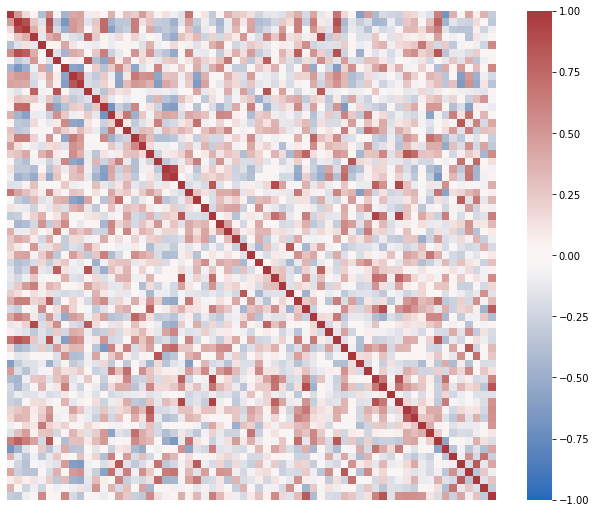

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=11,9
plt.figure(figsize=(11,9))
sns.heatmap(data=corr, vmin=-1, vmax=1, cmap="vlag", xticklabels=False, yticklabels=False, square=True)

Before calculating the network, I can do some quick pre-analysis by hierarchical clustering. First, because I want to consider both very negative and very positive correlations as significant, I'll calculate a dissimilarity matrix. The values of this matrix vary between 0 (most similar) and 1 (least similar). I'll then use a hierarchical clustering algorithm to determine the optimal arrangement of genes in the heatmap. This algorithm groups together highly correlated genes, which appear as squares along the center diagonal. The dendrograms on the top and side of the heatmap indicate how closely correlation patterns for the genes matched. Shorter lines represent very close matching.

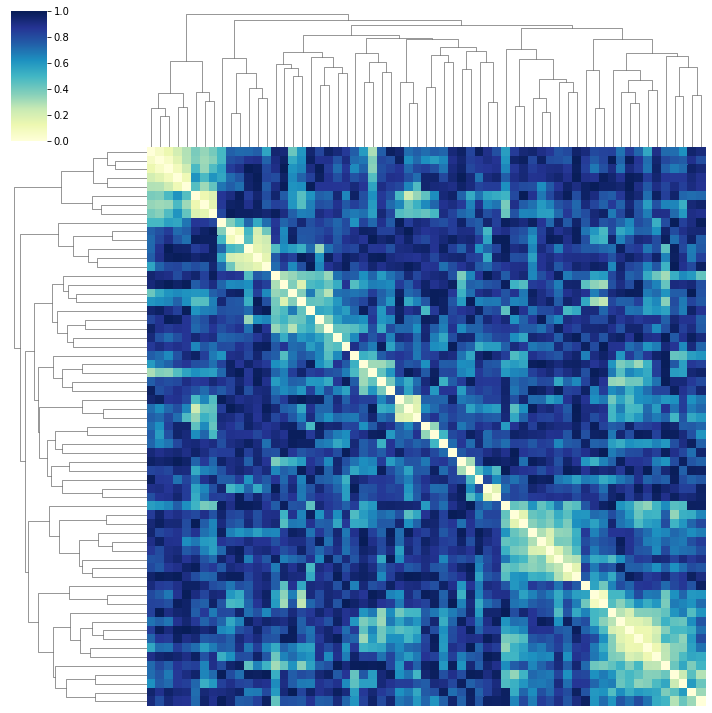

In [36]:
dissimilarity=1-np.abs(corr)
sns.clustermap(data=dissimilarity, vmin=0, vmax=1, xticklabels=False, yticklabels=False, cmap="YlGnBu")

## Filtering for significant correlations
The PCC matrix I just calculated contains correlations for every possible pairwise interaction. Now, I want to filter this matrix so that it includes only those correlations that are significant. To do this, I will create a histogram of the distribution of calculated PCC values and determine low and high PCC cutoffs. These cutoffs are calculated so that only the bottom and top 5% of interactions are considered to be significant.

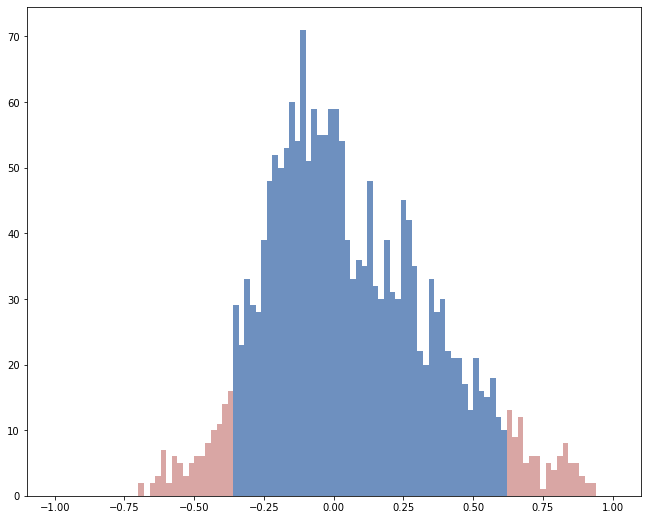

In [37]:
corrUpper = np.triu(corr, k=1)
corrList = corrUpper.flatten()
corrList = corrList[corrList!=0]

lowCutoff = np.percentile(corrList, 5)
highCutoff = np.percentile(corrList, 95)

n, bins, patches = plt.hist(corrList, bins=100, range=[-1, 1])
for c, p in zip(bins, patches):
    if c < lowCutoff:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[4])
    elif c >= lowCutoff and c < highCutoff:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[0])
    else:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[4])
plt.show()

Now, I create a dataframe of those genes involved in the most significant interactions.

In [38]:
networkEdges = pd.DataFrame(columns=["Gene1", "Gene2", "PCC"])

for gene1Ind in range(0, numSubsetGenes):
    gene1Name = subsetData.iloc[gene1Ind, 0]
    for gene2Ind in range(0, numSubsetGenes):
        gene2Name = subsetData.iloc[gene2Ind, 0]
        PCC = corrUpper[gene1Ind, gene2Ind]
        if PCC < lowCutoff or PCC > highCutoff:
           networkEdges = networkEdges.append({"Gene1":gene1Name, "Gene2":gene2Name, "PCC":PCC}, ignore_index=True)

## Creating the network and interpreting results
To create the final network, I consider all the genes in my dataset as "nodes", and all of the significant interactions that I found as "edges". Then, I'll draw the network, placing  nodes that are more highly connected closer together. Nodes which aren't highly connected, or even connected at all, at placed at the edge of the network.

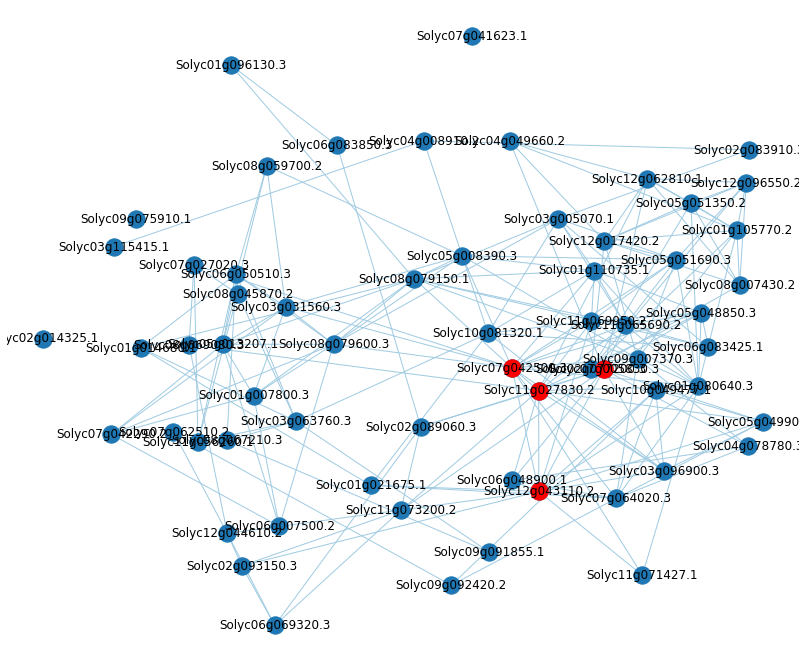

In [39]:
import networkx as nx
import operator as op

networkEdgesTuple = list(networkEdges.to_records(index=False))

networkGraph = nx.Graph()
networkGraph.add_nodes_from(subsetData.iloc[:, 0])
networkGraph.add_weighted_edges_from(networkEdgesTuple, weight="PCC")

nodeConnectivity = networkGraph.degree()
hubGenes = []
for gene in range(-1, -round(numSubsetGenes/12), -1):
    x = sorted(nodeConnectivity, key=op.itemgetter(1))[gene]
    hubGenes.append(x[0])
hubGenes = tuple(hubGenes)

pos = nx.spring_layout(networkGraph, k=0.75, iterations=50)
options = {
    "edge_color": "#A0CBE2",
    "width": 1
}
nx.draw(networkGraph, pos, with_labels=True, **options)
options = {
    "node_size": 300,
    "node_color": "r"
}
nx.draw_networkx_nodes(networkGraph, pos, nodelist=hubGenes, **options)
plt.show()

I've highlighted several of the most highly connected nodes in red. Because of their high connectivity, these nodes are referred to as "hub" nodes. Typically in a gene network analysis, hub nodes correspond to transcription factors, which can control the expression level of many genes.

In [40]:
hubGenes = list(hubGenes)
hubGeneInds = subsetData["Gene"].str.contains("|".join(hubGenes))
hubGeneData = subsetData[np.array(hubGeneInds, dtype=bool)]
hubGeneData.iloc[:, 0:6]


,Gene,Chromosome,Start,End,Strand,Description
1,Solyc07g042500.3,SL3.0ch07,55897938,55898954,+,"Alpha/beta-Hydrolases superfamily ""protein,"" p..."
12,Solyc12g043110.2,SL3.0ch12,59704996,59705237,-,LETSW12
20,Solyc07g005830.3,SL3.0ch07,665628,666088,+,Translation initiation factor IF-3 (AHRD V3.3 ...
21,Solyc11g027830.2,SL3.0ch11,19135869,19136532,+,ATP-dependent protease La (LON) domain protein...


## Conclusion
Gene network analysis is a powerful tool for elucidation of gene-gene interactions. These interactions need to be verified with wet lab techniques, such as yeast 2 hybrid assays. Gene networks can be established solely from genotypic data (i.e. expression data), as was demonstrated in this example. However, with the addition of phenotypic data, such as metabolite concentrations, a co-expression network can be generated. I plan to demonstrate how a co-expression network can be developed from this same MicroTom dataset in my next project.

## References
Li, Y., Chen, Y., Zhou, L., You, S., Deng, H., Chen, Y., Alseekh, S., Yuan, Y., Fu, R., Zhang, Z., Su, D., Fernie, A. R., Bouzayen, M., Ma, T., Liu, M., & Zhang, Y. (2020). MicroTom Metabolic Network: Rewiring Tomato Metabolic Regulatory Network throughout the Growth Cycle. Molecular Plant, 13(8), 1203–1218. https://doi.org/10.1016/j.molp.2020.06.005

Wang, L.-Q., Zhao, L.-H., & Qiao, Y.-Z. (2016). Identification of potential therapeutic targets for lung cancer by bioinformatics analysis. Molecular Medicine Reports, 13(3), 1975–1982. https://doi.org/10.3892/mmr.2015.4752

